In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

df = pd.read_csv('train.csv')

/home/kyohei/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
df['FamilySize'] = df['SibSp'] + df['Parch']

df['NameLength'] = df['Name'].apply(lambda x: len(x))

In [3]:
#getting title from Name column
def get_title(name):
    #Use a regular expression to search for title. titles always consist of capital and lowercase letters, and end with prediod.
    title_search = re.search(' ([A-Za-z]+)\.',name)
    #if the title exist, extract and return it
    if title_search:
        return title_search.group(1)
    return ''

In [4]:
#get all the titles and print how often each one occurs
titles = df['Name'].apply(get_title)
print(pd.value_counts(titles))

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
Name: Name, dtype: int64


In [5]:
#map each title to an integer.some titles are rare,and are compressed into the same codes as other titles.
title_mapping = {'Mr':1,'Miss':2,'Mrs':3,'Master':4,'Dr':5,'Rev':5,'Col':5,'Major':5,'Mlle':2,'Countess':5,
                 'Ms':2,'Lady':5,'Jonkheer':5,'Don':5,'Mme':2,'Capt':5,'Sir':5}
titles = titles.map(title_mapping)

In [6]:
df['Title'] = titles

In [7]:
import operator

#A dictionary mapping family name to id
family_id_mapping = {}
#A function to get the id given a row
def get_family_id(row):
    #Find the last name by splitting on a comma
    last_name = row['Name'].split(',')[0]
    #Create the family id
    family_id = '{0}{1}'.format(last_name, row['FamilySize'])
    #Look up the id in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            #Get the maximum id from the mapping and add one to it if we don't have an id
            current_id = (max(family_id_mapping.items(),key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]
#Get the family ids with the apply method
family_ids = df.apply(get_family_id,axis=1)

family_ids[df['FamilySize'] < 2] = -1

df['FamilyId'] = family_ids

In [8]:
#convert sex
sex_mapping = {'female':0,'male':1}
df['Sex'] = df['Sex'].map(sex_mapping)

In [9]:
#insert missing age values , using median value
from sklearn.preprocessing import Imputer
imr_age = Imputer(missing_values='NaN',strategy='median',axis=0)
imr_age.fit(df[['Age']].values)
df['Age'] = imr_age.transform(df[['Age']].values)

In [10]:
#Next parameter is Embarked.strategy is frequent so recreate Imputer object
imr = Imputer(missing_values='NaN',strategy='most_frequent')
#Imputer only can numeric values ,so convert str into numeric using map function
#create dictionary
embarked_mapping = {'C':1,'Q':2,'S':3}
#convert usinig map function
embarked_int = df['Embarked'].map(embarked_mapping)
#Imputing
df['Embarked'] = imr.fit_transform(embarked_int[:,np.newaxis])

In [11]:
features = [u'Pclass',u'Sex', u'Age',u'SibSp', u'Parch', u'Fare', u'Embarked'
            ,u'FamilySize', u'NameLength', u'Title', u'FamilyId']
X = df[features].values
y = df['Survived'].values

In [12]:
#analysis importance of features using random forest
from sklearn.ensemble import RandomForestClassifier
#name of features
feat_labels = np.array(features)
# craete random forest object
forest = RandomForestClassifier(n_estimators=500,random_state=0,n_jobs=-1)
#fitting the model
forest.fit(X,y)
#extract importance of features
importances = forest.feature_importances_
#extract index of features importance with decend
indices = np.argsort(importances)[::-1]
#print importances
for i in range(X.shape[1]):
    print('%2d) %-*s %f') %(i+1,30,feat_labels[indices[i]],importances[indices[i]])

 1) Fare                           0.179711
 2) NameLength                     0.161084
 3) Title                          0.157541
 4) Age                            0.150108
 5) Sex                            0.133963
 6) Pclass                         0.072532
 7) FamilySize                     0.041394
 8) FamilyId                       0.032913
 9) Embarked                       0.028281
10) SibSp                          0.026758
11) Parch                          0.015715


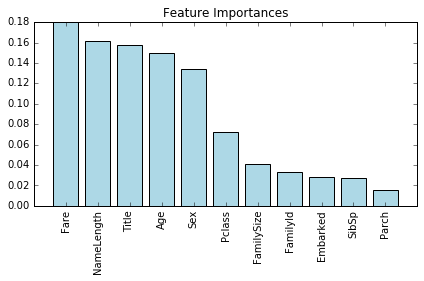

In [13]:
#plot features importances
plt.title('Feature Importances')
plt.bar(range(X.shape[1]),importances[indices],color='lightblue',align='center')
plt.xticks(range(X.shape[1]),feat_labels[indices],rotation=90)
plt.xlim([-1,X.shape[1]])
plt.tight_layout()
plt.show()

In [14]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    
    def __init__(self,estimator,k_features,scoring=accuracy_score,test_size=0.25,random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self,X,y):
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=self.test_size,random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train,y_train,X_test,y_test,self.indices_)
        
        self.scores_ = [score]
        
        while dim > self.k_features:
            
            scores = []
            subsets = []
            
            for p in combinations(self.indices_,r=dim-1):
                score = self._calc_score(X_train,y_train,X_test,y_test,p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            
            dim -= 1
            
            self.scores_.append(scores[best])
            
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self,X):
        return X[:, self.indices_]
    
    def _calc_score(self,X_train,y_train,X_test,y_test,indices):
        self.estimator.fit(X_train[:,indices],y_train)
        y_pred = self.estimator.predict(X_test[:,indices])
        score = self.scoring(y_test,y_pred)
        return score

In [15]:
#train,test split
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

# Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

pipe_lr = Pipeline([('scl',StandardScaler()),('clf',LogisticRegression())])
pipe_lr.fit(X_train,y_train)
y_test_pred = pipe_lr.predict(X_test)
y_train_pred = pipe_lr.predict(X_train)
print('train accuracy score: %.3f') %accuracy_score(y_train,y_train_pred)
print('test accuracy score: %.3f') %accuracy_score(y_test,y_test_pred)

train accuracy score: 0.827
test accuracy score: 0.810


# grid search

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
pipe_lr = Pipeline([('scl',StandardScaler()),('clf',LogisticRegression())])
params_range = [10**(i) for i in np.arange(-4,5,1)]
param_grid = [{'clf__C':params_range,'clf__penalty':['l1']},
             {'clf__C':params_range,'clf__penalty':['l2']}]

gs = GridSearchCV(estimator=pipe_lr,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,n_jobs=-1)
gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_params_)

0.821829855538
{'clf__penalty': 'l1', 'clf__C': 10}


# sbs algorithm

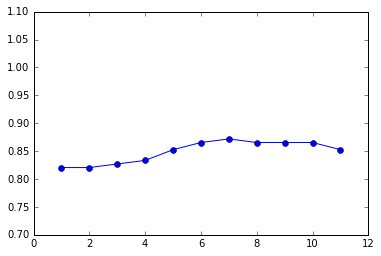

('best features set:', (0, 1, 2, 3, 4, 8, 9))


In [20]:
pipe_lr_best = Pipeline([('scl',StandardScaler()),('clf',LogisticRegression(penalty='l1',C=10))])
sbs = SBS(pipe_lr_best,k_features=1)
sbs.fit(X_train,y_train)

k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat,sbs.scores_,marker='o')
plt.ylim([0.7,1.1])
plt.show()

print('best features set:',sbs.subsets_[4])

# k-fold cross_validation

In [23]:
from sklearn.cross_validation import StratifiedKFold

kfold = StratifiedKFold(y=y_train,n_folds=10,random_state=0)
scores = []
for k, (train,test) in enumerate(kfold):
    pipe_lr_best.fit(X_train[train][:,sbs.subsets_[4]],y_train[train])
    score = pipe_lr_best.score(X_train[test][:,sbs.subsets_[4]],y_train[test])
    scores.append(score)
    print('Fold %s,Class dist: %s, Acc:%.3f') %(k+1,np.bincount(y_train[train]),score)
print('CV_accuracy: %.3f +/- %.3f') %(np.mean(scores),np.std(scores))

Fold 1,Class dist: [342 217], Acc:0.781
Fold 2,Class dist: [343 217], Acc:0.810
Fold 3,Class dist: [343 218], Acc:0.823
Fold 4,Class dist: [343 218], Acc:0.774
Fold 5,Class dist: [343 218], Acc:0.855
Fold 6,Class dist: [343 218], Acc:0.806
Fold 7,Class dist: [343 218], Acc:0.823
Fold 8,Class dist: [343 218], Acc:0.806
Fold 9,Class dist: [343 218], Acc:0.871
Fold 10,Class dist: [343 218], Acc:0.887
CV_accuracy: 0.824 +/- 0.035


In [25]:
pipe_lr_best.fit(X[:,sbs.subsets_[4]],y)
predict = pipe_lr_best.predict(X[:,sbs.subsets_[4]])
print(accuracy_score(predict,y))

0.814814814815


# SVC

In [28]:
from sklearn.svm import SVC
pipe_svc = Pipeline([('scl',StandardScaler()),('clf',SVC(random_state=1))])
pipe_svc.fit(X_train,y_train)
predict_train = pipe_svc.predict(X_train)
predict_test = pipe_svc.predict(X_test)
print('train accuracy: %.3f') % accuracy_score(y_train,predict_train)
print('test accuracy: %.3f') % accuracy_score(y_test,predict_test)

train accuracy: 0.849
test accuracy: 0.821


In [ ]:
params_range = [10**i for i in np.arange(-4,5,1)]
param_grid = [{'clf__C':params_range,'clf__kernel':['linear']},
             {'clf__C':params_range,'clf__gamma':params_range,'clf__kernel':['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                  scoring='accuracy',
                 cv=10,
                  n_jobs=-1)
gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
pipe_svc_best = Pipeline([('scl',StandardSclaer()),('clf',SVC(C=,gamma=,kernel=''))])
sbs = SBS(pipe_svc_best,k_features=1)
sbs.fit(X_train,y_train)

k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat,sbs.scores_,marker='o')
plt.ylim([0.7,1.1])
plt.show()

print('best features set:',sbs.subsets_[4])